<img src="./assets/img/teclab_logo.png" alt="Teclab logo" width="170">

**Author**: Hector Vergara ([LinkedIn](https://www.linkedin.com/in/hector-vergara/))

**Repository**: [nlp_apis](https://github.com/hhvergara/nlp_apis)

**Python Notebook**: [API4.ipynb](https://github.com/hhvergara/nlp_apis/blob/main/API4.ipynb)

----

# API 4:

### Contexto

Una vez lograda la representación vectorial del texto, se argumenta que ahora sí se ha conseguido una data estructurada gracias al preprocesamiento de texto, y que este resultado, a su vez, puede ser INPUT para un modelo.

Una vez más, alguien del equipo expresa que quiere aplicar una regresión lineal, a lo que contestamos que no se puede porque el target de este problema no es numérico, y más bien hay que ponerse a trabajar en un modelo supervisado para clasificación.
¿Qué modelos se aplicarán?

### Consignas

Modelo machine learning. Aplique un modelo machine learning -de los que Ud. ya conoce- para el problema de clasificación.

Se pueden utilizar los modelos de aprendizaje supervisado, tales como: random forest, support vector machine, vecinos más cercanos (KNN), regresión logística, o Naïve Bayes. El modelo debe ajustarse con los vectores de la muestra de entrenamiento. Es importante que se considere que el target es multinomial y no binomial (sobre todo en la regresión logística).

Evaluación del modelo. Según las predicciones de la muestra de testeo, realice la evaluación del modelo. Para ello, calcule los índices de desempeño como acuracidad, recall y precisión. Interprete los resultados y exponga sus conclusiones.



In [1]:
# 1. Library Imports
import os
import nltk
import numpy as np
import pandas as pd
from pathlib import Path
from nltk import pos_tag
from nltk.corpus import wordnet
from  nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score


__version__ = '0.0.1'
__email__ = 'hhvservice@gmail.com'
__author__ = 'Hector Vergara'
__annotations__ = 'https://www.linkedin.com/in/hector-vergara/'
__base_dir__ = Path().absolute()
__data_dir__ = os.path.join(__base_dir__, 'data')
filename_data = os.path.join(__data_dir__, 'sentiment_analysis_dataset.csv')

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hvergara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hvergara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/hvergara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/hvergara/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/hvergara/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hvergara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Descargamos el dataset "sentiment-analysis-dataset" de kaggle para realizar las pruebas.

Referencia: https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset/data

In [2]:
# Load the dataset
df = pd.read_csv(filename_data, sep=',', encoding='unicode_escape')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head(10)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,night,70-100,Antigua and Barbuda,97929,440.0,223
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,morning,0-20,Argentina,45195774,2736690.0,17
7,50e14c0bb8,Soooo high,Soooo high,neutral,noon,21-30,Armenia,2963243,28470.0,104
8,e050245fbd,Both of you,Both of you,neutral,night,31-45,Australia,25499884,7682300.0,3
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,morning,46-60,Austria,9006398,82400.0,109


In [3]:
print(f'''
Cantidad de filas: {df.shape[0]}
Cantidad de columnas: {df.shape[1]}
''')


Cantidad de filas: 27480
Cantidad de columnas: 10



## Preprocesamiento de los datos

In [4]:
class NLPPreprocessor:

    tokenizer_pattern = (
            r'[\U0001F600-\U0001F64F]'          # classic emojis
            r'|[\U0001F300-\U0001F5FF]'         # nature, symbols
            r'|[\U0001F680-\U0001F6FF]'         # transport
            r'|[\U0001F1E0-\U0001F1FF]'         # Flags
            r'|[\U00002700-\U000027BF]'         # various symbols
            r'|[\U0001F900-\U0001F9FF]'         # gestures
            r'|[\U00002600-\U000026FF]'         # ☀☂
            r'|❤|🥰'                            # specific emojis
            r'|:\)'                             # emoticon :)
            r'|\b\w+\b'                         # words (alphanumeric)
        )

    def __init__(self, text_column: str):
        self.text_column = text_column

    def clean_tokenize_text(self, text: str) -> list:
        """ Tokenizes text and removes emojis, emoticons, and special characters."""

        tokenizer = RegexpTokenizer(self.tokenizer_pattern)
        return tokenizer.tokenize(text.lower())

    def _get_wordnet_pos_(self, treebank_tag) -> str:
        """
        Converts nltk (Treebank) POS tags to WordNet tags.
        """
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN  # By default, use NOUN if no match found


    def lemmatize_tokens(self, tokens: list) -> list:
        """Lemmatize tokens using POS tagging for greater accuracy."""
        lemmatizer = WordNetLemmatizer()
        pos_tags = pos_tag(tokens)  # [('los', 'DT'), ('niños', 'NNS'), ...]
        return [
            lemmatizer.lemmatize(token, self._get_wordnet_pos_(pos))
            for token, pos in pos_tags
        ]

    def stem_tokens(self, tokens: list) -> list:
        """Stem tokens using PorterStemmer."""
        stemmer = PorterStemmer().stem
        return [stemmer(token) for token in tokens]

    def preprocess(self, df: pd.DataFrame) -> pd.DataFrame:
        df['tokens'] = df[self.text_column].astype(str).apply(self.clean_tokenize_text)
        df['lemmas'] = df['tokens'].apply(self.lemmatize_tokens)
        df['stems'] = df['tokens'].apply(self.stem_tokens)
        return df

In [5]:
# Example usage:
preprocessor = NLPPreprocessor(text_column='text')
processed_df = preprocessor.preprocess(df)
processed_df.head(10)


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),tokens,lemmas,stems
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60,"[i, d, have, responded, if, i, were, going]","[i, d, have, respond, if, i, be, go]","[i, d, have, respond, if, i, were, go]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105,"[sooo, sad, i, will, miss, you, here, in, san,...","[sooo, sad, i, will, miss, you, here, in, san,...","[sooo, sad, i, will, miss, you, here, in, san,..."
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18,"[my, boss, is, bullying, me]","[my, bos, be, bully, me]","[my, boss, is, bulli, me]"
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164,"[what, interview, leave, me, alone]","[what, interview, leave, me, alone]","[what, interview, leav, me, alon]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26,"[sons, of, why, couldn, t, they, put, them, on...","[son, of, why, couldn, t, they, put, them, on,...","[son, of, whi, couldn, t, they, put, them, on,..."
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,night,70-100,Antigua and Barbuda,97929,440.0,223,"[http, www, dothebouncy, com, smf, some, shame...","[http, www, dothebouncy, com, smf, some, shame...","[http, www, dothebounci, com, smf, some, shame..."
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,morning,0-20,Argentina,45195774,2736690.0,17,"[2am, feedings, for, the, baby, are, fun, when...","[2am, feeding, for, the, baby, be, fun, when, ...","[2am, feed, for, the, babi, are, fun, when, he..."
7,50e14c0bb8,Soooo high,Soooo high,neutral,noon,21-30,Armenia,2963243,28470.0,104,"[soooo, high]","[soooo, high]","[soooo, high]"
8,e050245fbd,Both of you,Both of you,neutral,night,31-45,Australia,25499884,7682300.0,3,"[both, of, you]","[both, of, you]","[both, of, you]"
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,morning,46-60,Austria,9006398,82400.0,109,"[journey, wow, u, just, became, cooler, hehe, ...","[journey, wow, u, just, become, cool, hehe, be...","[journey, wow, u, just, becam, cooler, hehe, i..."


In [6]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(processed_df, test_size=0.2, random_state=42)

x_train = train_df['text']
x_test = test_df['text']
y_train = train_df['sentiment']
y_test = test_df['sentiment']

print(f'''Cantidad de filas en train: {train_df.shape[0]}
Cantidad de columnas en train: {train_df.shape[1]}
Cantidad de filas en test: {test_df.shape[0]}
Cantidad de columnas en test: {test_df.shape[1]}
''')

Cantidad de filas en train: 21984
Cantidad de columnas en train: 13
Cantidad de filas en test: 5496
Cantidad de columnas en test: 13



In [7]:
# Model creation using TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(token_pattern=r'[^\s]+', ngram_range=(1, 2), max_features=30000)

# Vectorize the text data
tfidf_x_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_x_test = tfidf_vectorizer.transform(x_test)

print(f'''tfidf_x_train shape: {tfidf_x_train.shape}\ntfidf_x_test shape: {tfidf_x_test.shape}''')

tfidf_x_train shape: (21984, 30000)
tfidf_x_test shape: (5496, 30000)


In [8]:
# Get feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix back to a DataFrame
tfidf_x_train_df = pd.DataFrame(tfidf_x_train.toarray(), columns=feature_names)
tfidf_x_test_df = pd.DataFrame(tfidf_x_test.toarray(), columns=feature_names)

print(f'''tfidf_x_train_df shape: {tfidf_x_train_df.shape}\ntfidf_x_test_df shape: {tfidf_x_test_df.shape}''')

tfidf_x_train_df shape: (21984, 30000)
tfidf_x_test_df shape: (5496, 30000)


In [9]:
# Display the first 10 rows of the TF-IDF DataFrame
tfidf_x_train_df.head(10)


,!,! !,! 1,! <3,! but,! i,! i`ve,! it`s,! its,! lol,...,zombies,zone,zoo,~,~ and,~ ~,ã¯â¿â½,ã¯â¿â½6,ã¯â¿â½6 free,ã¯â¿â½you
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Display the first 10 rows of the TF-IDF test DataFrame
tfidf_x_test_df.head(10)


,!,! !,! 1,! <3,! but,! i,! i`ve,! it`s,! its,! lol,...,zombies,zone,zoo,~,~ and,~ ~,ã¯â¿â½,ã¯â¿â½6,ã¯â¿â½6 free,ã¯â¿â½you
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 💡 Etapa de entrenamiento de modelos
Ahora evaluaremos diferentes modelos de clasificación, luego los compararemos entre sí para quedarnos con el mejor.

### ✅ Entrenamiento del modelo: Random Forest Classifier
Entrenamos un modelo supervisado de clasificación multiclase con los vectores TF-IDF.

In [11]:
# Create and train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(tfidf_x_train, y_train)

# Make predictions
y_pred = clf.predict(tfidf_x_test)

# Model evaluation
random_forest_accuracy = accuracy_score(y_test, y_pred)
random_forest_precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
random_forest_recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
random_forest_classification_report = classification_report(y_test, y_pred, zero_division=0)

print("📊 Resultados de evaluación:")
print(f"Accuracy:  {random_forest_accuracy:.4f}")
print(f"Precision: {random_forest_precision:.4f}")
print(f"Recall:    {random_forest_recall:.4f}\n")

# Complete report:
print("📋 Classification Report:")
print(random_forest_classification_report)


📊 Resultados de evaluación:
Accuracy:  0.6363
Precision: 0.6569
Recall:    0.6363

📋 Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.43      0.53      1572
     neutral       0.57      0.78      0.65      2236
    positive       0.76      0.64      0.70      1688

    accuracy                           0.64      5496
   macro avg       0.67      0.62      0.63      5496
weighted avg       0.66      0.64      0.63      5496



### ✅ Modelo: Naive Bayes (MultinomialNB)
Probaremos ahora con un modelo de Naive Bayes, que suele tener buen rendimiento con TF-IDF en clasificación de texto.

In [12]:
# Training Naive Bayes model
nb = MultinomialNB()
nb.fit(tfidf_x_train, y_train)

# Prediction
y_pred_nb = nb.predict(tfidf_x_test)

# Evaluation
naive_bayes_accuracy = accuracy_score(y_test, y_pred_nb)
naive_bayes_precision = precision_score(y_test, y_pred_nb, average='weighted', zero_division=0)
naive_bayes_recall = recall_score(y_test, y_pred_nb, average='weighted', zero_division=0)
naive_bayes_classification_report = classification_report(y_test, y_pred_nb, zero_division=0)

print("📊 Resultados Naive Bayes:")
print(f"Accuracy:  {naive_bayes_accuracy:.4f}")
print(f"Precision: {naive_bayes_precision:.4f}")
print(f"Recall:    {naive_bayes_recall:.4f}\n")

# complete report
print("📋 Classification Report:")
print(naive_bayes_classification_report)


📊 Resultados Naive Bayes:
Accuracy:  0.6186
Precision: 0.6686
Recall:    0.6186

📋 Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.38      0.51      1572
     neutral       0.54      0.83      0.65      2236
    positive       0.77      0.56      0.65      1688

    accuracy                           0.62      5496
   macro avg       0.69      0.59      0.60      5496
weighted avg       0.67      0.62      0.61      5496



### ✅ Modelo: Regresión Logística Multinomial
Utilizamos un modelo lineal eficiente que soporta clasificación multiclase.

In [13]:
# Training Logistic Regression model
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
lr.fit(tfidf_x_train, y_train)

# Predictions
y_pred_lr = lr.predict(tfidf_x_test)

# Evaluation
logistic_regression_accuracy = accuracy_score(y_test, y_pred_lr)
logistic_regression_precision = precision_score(y_test, y_pred_lr, average='weighted', zero_division=0)
logistic_regression_recall = recall_score(y_test, y_pred_lr, average='weighted', zero_division=0)
logistic_regression_classification_report = classification_report(y_test, y_pred_lr, zero_division=0)

print("📊 Resultados Logistic Regression:")
print(f"Accuracy:  {logistic_regression_accuracy:.4f}")
print(f"Precision: {logistic_regression_precision:.4f}")
print(f"Recall:    {logistic_regression_recall:.4f}\n")

# Complete report
print("📋 Classification Report:")
print(logistic_regression_classification_report)


/Users/hvergara/Documents/Teclab/nlp_apis/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


📊 Resultados Logistic Regression:
Accuracy:  0.6557
Precision: 0.6652
Recall:    0.6557

📋 Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.55      0.61      1572
     neutral       0.59      0.72      0.65      2236
    positive       0.75      0.67      0.71      1688

    accuracy                           0.66      5496
   macro avg       0.67      0.65      0.66      5496
weighted avg       0.67      0.66      0.66      5496



### ✅ Modelo: Regresión Logística con GridSearchCV
En este caso, vamos a tratar de encontrar los mejores hiperparámetros para la regresión logística, utilizando Grid Search, tratando de conseguir el mejor resultado posible para nuestro modelo.

In [14]:

# Defining searching space
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'multi_class': ['multinomial']
}

# Model base creation:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# GridSearch with cross-validation (cv=3)
grid_search = GridSearchCV(log_reg, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(tfidf_x_train, y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Users/hvergara/Documents/Teclab/nlp_apis/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hvergara/Documents/Teclab/nlp_apis/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hvergara/Documents/Teclab/nlp_apis/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hvergara/Documents/Teclab/n

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'multi_class': ['multinomial'], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring='accuracy', verbose=1)

In [15]:
print("🔧 Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print("Mejor accuracy promedio en CV:", grid_search.best_score_)


🔧 Mejores hiperparámetros encontrados:
{'C': 1, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}
Mejor accuracy promedio en CV: 0.6539301310043668


In [16]:
# Best model and predictions
# Get the best model from GridSearch:
logistic_regression_best_model = grid_search.best_estimator_

# Predictions using the best model
y_pred_best = logistic_regression_best_model.predict(tfidf_x_test)

# Evaluation of the best model
logistic_regression_best_model_accuracy = accuracy_score(y_test, y_pred_best)
logistic_regression_best_model_precision = precision_score(y_test, y_pred_best, average='weighted', zero_division=0)
logistic_regression_best_model_recall = recall_score(y_test, y_pred_best, average='weighted', zero_division=0)
logistic_regression_best_model_classification_report = classification_report(y_test, y_pred_best, zero_division=0)

print("📊 Resultados fine-tuned Logistic Regression:")
print("Accuracy:", logistic_regression_best_model_accuracy)
print("Precision:", logistic_regression_best_model_precision)
print("Recall:", logistic_regression_best_model_recall)
print("\n📋 Classification Report:\n", logistic_regression_best_model_classification_report)


📊 Resultados fine-tuned Logistic Regression:
Accuracy: 0.6557496360989811
Precision: 0.6652183627535289
Recall: 0.6557496360989811

📋 Classification Report:
               precision    recall  f1-score   support

    negative       0.67      0.55      0.61      1572
     neutral       0.59      0.72      0.65      2236
    positive       0.75      0.67      0.71      1688

    accuracy                           0.66      5496
   macro avg       0.67      0.65      0.66      5496
weighted avg       0.67      0.66      0.66      5496



---

## ✅ Comparación de desempeño entre modelos

A continuación, comparamos las métricas clave (**accuracy**, **precision**, y **recall**) de los distintos modelos de clasificación evaluados:

- Random Forest
- Naive Bayes
- Logistic Regression
- Logistic Regression (GridSearchCV)

Este gráfico nos permite visualizar rápidamente cuál modelo presenta un mejor equilibrio entre precisión, recuperación y desempeño general.

---


📊 Métricas consolidadas:
                Modelo  Accuracy  Precision    Recall
0        Random Forest  0.636281   0.656929  0.636281
1          Naive Bayes  0.618632   0.668643  0.618632
2  Logistic Regression  0.655750   0.665218  0.655750
3    LogReg GridSearch  0.655750   0.665218  0.655750


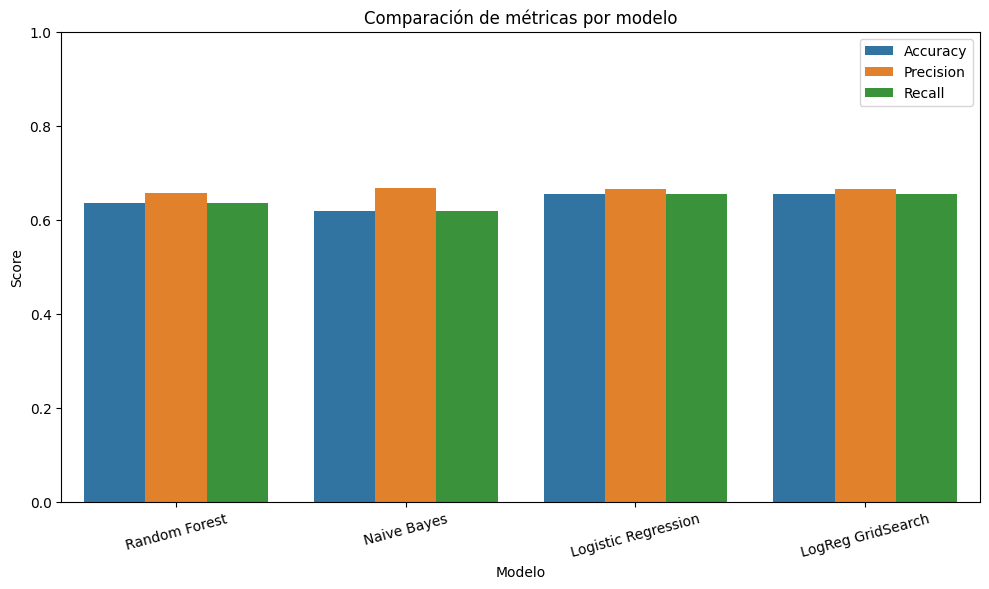

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# We consolidate the metrics into a DataFrame
model_metrics = pd.DataFrame({
    'Modelo': ['Random Forest', 'Naive Bayes', 'Logistic Regression', 'LogReg GridSearch'],
    'Accuracy': [
        random_forest_accuracy,
        naive_bayes_accuracy,
        logistic_regression_accuracy,
        logistic_regression_best_model_accuracy
    ],
    'Precision': [
        random_forest_precision,
        naive_bayes_precision,
        logistic_regression_precision,
        logistic_regression_best_model_precision
    ],
    'Recall': [
        random_forest_recall,
        naive_bayes_recall,
        logistic_regression_recall,
        logistic_regression_best_model_recall
    ]
})

# We melt the DataFrame to graph in long format
metrics_melted = model_metrics.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')

print("📊 Métricas consolidadas:")
print(model_metrics)

# Create a bar plot to compare the metrics across models:
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x='Modelo', y='Valor', hue='Métrica')
plt.title('Comparación de métricas por modelo')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xticks(rotation=15)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


---

## ✅ Conclusiones finales

Luego de aplicar diferentes modelos de clasificación sobre el dataset de análisis de sentimientos, pudimos evaluar su desempeño a través de métricas clave: **accuracy**, **precision** y **recall**.

| Modelo                 | Accuracy | Precision | Recall  |
|------------------------|----------|-----------|---------|
| Random Forest          | 0.636    | 0.657     | 0.636   |
| Naive Bayes            | 0.619    | 0.669     | 0.619   |
|✔️ Logistic Regression    | **0.656**| **0.665** | **0.656** |
| LogReg GridSearchCV    | 0.656    | 0.665     | 0.656   |

**Principales conclusiones:**

- El modelo con **mejor desempeño global fue la Regresión Logística**, tanto en métricas individuales como en consistencia entre ellas.
- **Naive Bayes** resultó competitivo en **precisión**, pero mostró menor capacidad de recuperación (recall).
- **Random Forest** fue robusto, aunque quedó por debajo en las tres métricas.
- El **ajuste de hiperparámetros (GridSearchCV)** no generó mejoras significativas en este caso, indicando que el modelo ya estaba bien calibrado con los parámetros por defecto.

En base a los resultados obtenidos, se recomienda utilizar **Logistic Regression como modelo base** para futuras etapas del pipeline de análisis de sentimientos.

---

> 💡 Como siguiente paso, podría considerarse el uso de modelos de lenguaje más avanzados como BERT o técnicas de word embeddings si se desea mejorar aún más la comprensión semántica del texto.

---
